# Exp 40

### Compare all pairs of classes. How easy is to distinguish between them?

In [1]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp40'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

# Create models

In [8]:
cats = rawset.categories
tsets, vsets = rawset.rnd_split_fraction_by_category(0.5)
tsets = tsets.by_category()
vsets = vsets.by_category()
r = report.Reporter2(result_dir + '/creation.tsv')
for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        print(cats[i], cats[j])
        tset = tsets[cats[i]].join(tsets[cats[j]])
        vset = vsets[cats[i]].join(vsets[cats[j]])
        model = models.C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D(
            2, 8, 'softmax', 'categorical_crossentropy')
        result = Trainer(model).train(tset, vset)
        h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
        model.save(h5_path)
        r.line(cat1=cats[i],
               cat2=cats[j],
               elapsed=result.elapsed,
               **report.report_epochs(**result._asdict()),
               **report.report_metrics(**result._asdict()),
              )
r.close()

csv dbase3
csv doc
csv dwf
csv eps
csv f
csv gif
csv gz
csv hlp
csv html
csv java
csv jpg
csv kml
csv kmz
csv log
csv pdf
csv png
csv pps
csv ppt
csv pptx
csv ps
csv rtf
csv sql
csv swf
csv txt
csv wp
csv xls
csv xml
dbase3 doc
dbase3 dwf
dbase3 eps
dbase3 f
dbase3 gif
dbase3 gz
dbase3 hlp
dbase3 html
dbase3 java
dbase3 jpg
dbase3 kml
dbase3 kmz
dbase3 log
dbase3 pdf
dbase3 png
dbase3 pps
dbase3 ppt
dbase3 pptx
dbase3 ps
dbase3 rtf
dbase3 sql
dbase3 swf
dbase3 txt
dbase3 wp
dbase3 xls
dbase3 xml
doc dwf
doc eps
doc f
doc gif
doc gz
doc hlp
doc html
doc java
doc jpg
doc kml
doc kmz
doc log
doc pdf
doc png
doc pps
doc ppt
doc pptx
doc ps
doc rtf
doc sql
doc swf
doc txt
doc wp
doc xls
doc xml
dwf eps
dwf f
dwf gif
dwf gz
dwf hlp
dwf html
dwf java
dwf jpg
dwf kml
dwf kmz
dwf log
dwf pdf
dwf png
dwf pps
dwf ppt
dwf pptx
dwf ps
dwf rtf
dwf sql
dwf swf
dwf txt
dwf wp
dwf xls
dwf xml
eps f
eps gif
eps gz
eps hlp
eps html
eps java
eps jpg
eps kml
eps kmz
eps log
eps pdf
eps png
eps pps
eps ppt


# Load results

In [9]:
data = pd.read_csv(result_dir + '/creation.tsv', sep='\t')
data

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,csv,dbase3,58.379267,10,0.989250,0.989250
1,csv,doc,53.128949,9,0.970875,0.970875
2,csv,dwf,58.502680,10,0.991000,0.991000
3,csv,eps,70.442723,12,0.983375,0.983375
4,csv,f,104.412572,18,0.918625,0.918625
...,...,...,...,...,...,...
373,txt,xls,175.274781,14,0.979500,0.979500
374,txt,xml,193.281878,17,0.887125,0.887125
375,wp,xls,244.635365,25,0.936500,0.936500
376,wp,xml,202.362841,18,0.959375,0.959375


In [135]:
data = data.sort_values(['val_categorical_accuracy'])
data[data['val_categorical_accuracy'] < 0.7]

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
85,dwf,jpg,76.295992,10,0.558375,0.558375
323,pps,ppt,140.500756,12,0.559125,0.559125
171,gz,jpg,80.539145,7,0.560125,0.560125
314,png,pptx,130.596266,12,0.567750,0.567750
318,png,swf,109.400832,8,0.578750,0.578750
176,gz,png,98.515712,10,0.588500,0.588500
81,dwf,gz,92.508903,13,0.594250,0.594250
247,jpg,pps,103.041693,9,0.605750,0.605750
324,pps,pptx,205.976245,21,0.608875,0.608875
97,dwf,swf,114.132537,16,0.610125,0.610125


In [52]:
data2 = data.apply(
    lambda x: pd.Series(
        [
            rawset.cat_to_ix[x.cat1],
            rawset.cat_to_ix[x.cat2], 
            x.val_categorical_accuracy
        ], index=['cat1', 'cat2', 'val_acc'])
    , axis=1)
data2

,cat1,cat2,val_acc
0,0.0,1.0,0.989250
1,0.0,2.0,0.970875
2,0.0,3.0,0.991000
3,0.0,4.0,0.983375
4,0.0,5.0,0.918625
...,...,...,...
373,24.0,26.0,0.979500
374,24.0,27.0,0.887125
375,25.0,26.0,0.936500
376,25.0,27.0,0.959375


# PCA

In [10]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [124]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.500000,0.989250,0.970875,0.991000,0.983375,0.918625,0.999500,0.998250,0.968250,0.934375,...,0.980250,0.989625,0.982875,0.980000,0.898500,0.992875,0.905875,0.970375,0.982875,0.978125
1,0.989250,0.500000,0.992125,0.998375,0.989500,0.970750,0.999625,1.000000,0.982625,0.978125,...,0.988625,0.992750,0.998500,0.995625,0.990375,0.995750,0.977250,0.991750,0.996875,0.993750
2,0.970875,0.992125,0.500000,0.913625,0.975375,0.861500,0.958000,0.914500,0.927000,0.920500,...,0.863375,0.900375,0.967875,0.958000,0.911875,0.903000,0.886000,0.909125,0.842000,0.948875
3,0.991000,0.998375,0.913625,0.500000,0.996750,0.992000,0.917625,0.594250,0.996375,0.995000,...,0.702000,0.723875,0.984250,0.996375,0.986625,0.610125,0.970250,0.992875,0.992625,0.992500
4,0.983375,0.989500,0.975375,0.996750,0.500000,0.965750,0.991250,0.997250,0.982250,0.969500,...,0.971125,0.992750,0.712625,0.955625,0.969750,0.994000,0.942125,0.987250,0.985875,0.963250
5,0.918625,0.970750,0.861500,0.992000,0.965750,0.500000,0.987750,0.994500,0.831875,0.880875,...,0.975750,0.989750,0.929250,0.937125,0.840250,0.988750,0.712625,0.950500,0.978625,0.898875
6,0.999500,0.999625,0.958000,0.917625,0.991250,0.987750,0.500000,0.898375,0.999375,0.999875,...,0.920375,0.864500,0.983500,0.996625,0.996500,0.897875,0.999125,0.984750,0.990875,0.999625
7,0.998250,1.000000,0.914500,0.594250,0.997250,0.994500,0.898375,0.500000,0.999750,1.000000,...,0.677875,0.670625,0.984625,0.998750,0.997250,0.614000,0.999750,0.990125,0.992250,0.999500
8,0.968250,0.982625,0.927000,0.996375,0.982250,0.831875,0.999375,0.999750,0.500000,0.915750,...,0.987625,0.992875,0.979750,0.950750,0.876250,0.993000,0.826875,0.959625,0.980250,0.940875
9,0.934375,0.978125,0.920500,0.995000,0.969500,0.880875,0.999875,1.000000,0.915750,0.500000,...,0.985750,0.996000,0.962750,0.962375,0.886875,0.997375,0.806875,0.952875,0.981250,0.858000


In [125]:
data6 = pca.fit_transform(data5)

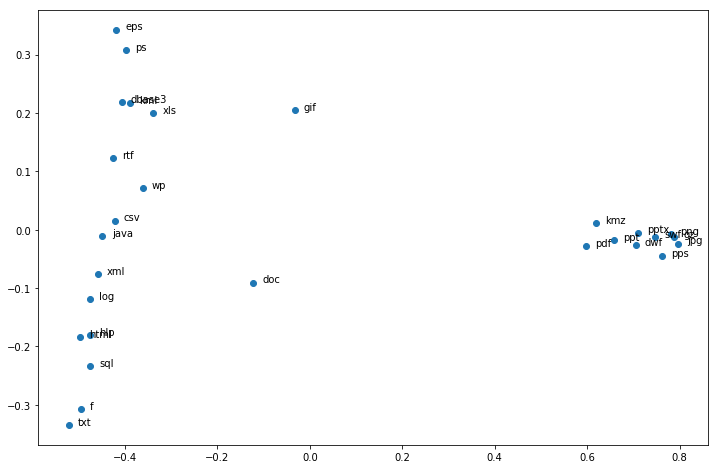

In [126]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data6[:,0], data6[:,1], 'o')
for i in range(28):
    ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.02, data6[i,1]))

# Multi-dimensional scaling

In [119]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.500000,0.989250,0.970875,0.991000,0.983375,0.918625,0.999500,0.998250,0.968250,0.934375,...,0.980250,0.989625,0.982875,0.980000,0.898500,0.992875,0.905875,0.970375,0.982875,0.978125
1,0.989250,0.500000,0.992125,0.998375,0.989500,0.970750,0.999625,1.000000,0.982625,0.978125,...,0.988625,0.992750,0.998500,0.995625,0.990375,0.995750,0.977250,0.991750,0.996875,0.993750
2,0.970875,0.992125,0.500000,0.913625,0.975375,0.861500,0.958000,0.914500,0.927000,0.920500,...,0.863375,0.900375,0.967875,0.958000,0.911875,0.903000,0.886000,0.909125,0.842000,0.948875
3,0.991000,0.998375,0.913625,0.500000,0.996750,0.992000,0.917625,0.594250,0.996375,0.995000,...,0.702000,0.723875,0.984250,0.996375,0.986625,0.610125,0.970250,0.992875,0.992625,0.992500
4,0.983375,0.989500,0.975375,0.996750,0.500000,0.965750,0.991250,0.997250,0.982250,0.969500,...,0.971125,0.992750,0.712625,0.955625,0.969750,0.994000,0.942125,0.987250,0.985875,0.963250
5,0.918625,0.970750,0.861500,0.992000,0.965750,0.500000,0.987750,0.994500,0.831875,0.880875,...,0.975750,0.989750,0.929250,0.937125,0.840250,0.988750,0.712625,0.950500,0.978625,0.898875
6,0.999500,0.999625,0.958000,0.917625,0.991250,0.987750,0.500000,0.898375,0.999375,0.999875,...,0.920375,0.864500,0.983500,0.996625,0.996500,0.897875,0.999125,0.984750,0.990875,0.999625
7,0.998250,1.000000,0.914500,0.594250,0.997250,0.994500,0.898375,0.500000,0.999750,1.000000,...,0.677875,0.670625,0.984625,0.998750,0.997250,0.614000,0.999750,0.990125,0.992250,0.999500
8,0.968250,0.982625,0.927000,0.996375,0.982250,0.831875,0.999375,0.999750,0.500000,0.915750,...,0.987625,0.992875,0.979750,0.950750,0.876250,0.993000,0.826875,0.959625,0.980250,0.940875
9,0.934375,0.978125,0.920500,0.995000,0.969500,0.880875,0.999875,1.000000,0.915750,0.500000,...,0.985750,0.996000,0.962750,0.962375,0.886875,0.997375,0.806875,0.952875,0.981250,0.858000


In [120]:
from sklearn.manifold import MDS

In [121]:
mds = MDS(n_components=2,max_iter=3000, eps=1e-9,
          n_jobs=1)

In [122]:
data7 = mds.fit_transform(data5)

/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


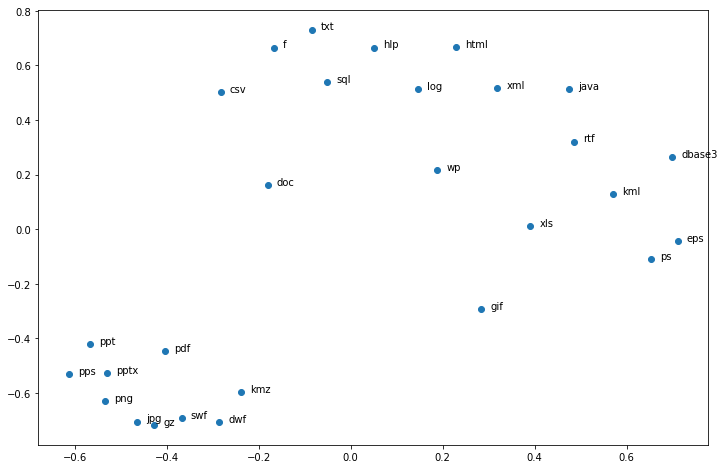

In [123]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(28):
    ax.annotate(rawset.ix_to_cat[i], (data7[i,0]+0.02, data7[i,1]))